# Ideal Diode Example

The simplest way to model a solar cell is as an **ideal diode**, described by the following equation:
$$J(V,T) = J_L+J_0(\exp{\frac{qV}{nkT}}-1)$$
where $k=8.61733\times 10^{-5}$ eV/K is Boltzmann's constant, by convention $J_L$ (the light current) is negative and $J_0$ (the saturation current) is positive but strongly dependent on temperature, a dependence we can approximate as:
$$J_0 \approx B'T^{3/n}\exp{\frac{-E_{g0}}{nkT}}$$
We'll use the silicon zero-temperature bandgap, $E_{g0}=1.2$ eV, meaning we just need to fit for $B'$ in this equation.
$J_L$ is typically directly proportional to light intensity, which we will treat as fixed for this example, leaving us with two parameters to fit for: $B'$ and the ideality factor $n$.

In [1]:
import numpy as np
import sys
import math
import pandas as pd
sys.path.append('../../')
import bayesim.model as bym
import bayesim.params as byp
import deepdish as dd
from jupyterthemes import jtplot
#jtplot.style('solarizedd')
jtplot.style('default')

## List the parameters
First, we list our fitting parameters.

In [2]:
fp = byp.Param_list()
fp.add_fit_param(name='Bp',val_range=[10,1000],spacing='log',length=10,units='arb.')
fp.add_fit_param(name='n',val_range=[1,2],length=10, min_width=0.06)

Setting min_width automatically for Bp.


We can inspect the `Param_list` object and see what kind of information is inside...

In [3]:
fp.as_dict()

{'ec_x_name': None,
 'ecs': [],
 'fit_params': [{'edges': array([   10.   ,    15.849,    25.12 ,    39.81 ,    63.1  ,   100.   ,
            158.49 ,   251.2  ,   398.1  ,   631.   ,  1000.   ]),
   'length': 10,
   'min_width': 1.0471285480508996,
   'name': 'Bp',
   'spacing': 'log',
   'tolerance': 1.0046157902783952,
   'units': 'arb.',
   'val_range': [10, 1000],
   'vals': array([  12.589,   19.953,   31.62 ,   50.12 ,   79.43 ,  125.89 ,
           199.53 ,  316.2  ,  501.2  ,  794.3  ])},
  {'edges': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0],
   'length': 10,
   'min_width': 0.06,
   'name': 'n',
   'spacing': 'linear',
   'tol_digits': 3,
   'tolerance': 0.006,
   'units': 'unitless',
   'val_range': [1, 2],
   'vals': [1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95]}],
 'output': []}

Note that there are both `edges` and `vals` computed - the `vals` will be the values at which computations will be done, while `edges` will be the edges of the grid, used in subdivision steps later on.

Finally, we define the measurement conditions and output variable. We won't be varying light intensity here, so we only need voltage and temperature.

In [4]:
fp.add_ec(name='V', units='V', is_x=True) # this will be on the x-axis when we plot data
fp.add_ec(name='T', units='K', tolerance=0.1)
fp.add_output(name='J', units='A/cm^2')

In [5]:
fp.as_dict()

{'ec_x_name': 'V',
 'ecs': [{'name': 'V',
   'param_type': 'input',
   'tol_digits': 6,
   'tolerance': 1e-06,
   'units': 'V'},
  {'name': 'T',
   'param_type': 'input',
   'tol_digits': 1,
   'tolerance': 0.1,
   'units': 'K'}],
 'fit_params': [{'edges': array([   10.   ,    15.849,    25.12 ,    39.81 ,    63.1  ,   100.   ,
            158.49 ,   251.2  ,   398.1  ,   631.   ,  1000.   ]),
   'length': 10,
   'min_width': 1.0471285480508996,
   'name': 'Bp',
   'spacing': 'log',
   'tolerance': 1.0046157902783952,
   'units': 'arb.',
   'val_range': [10, 1000],
   'vals': array([  12.589,   19.953,   31.62 ,   50.12 ,   79.43 ,  125.89 ,
           199.53 ,  316.2  ,  501.2  ,  794.3  ])},
  {'edges': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0],
   'length': 10,
   'min_width': 0.06,
   'name': 'n',
   'spacing': 'linear',
   'tol_digits': 3,
   'tolerance': 0.006,
   'units': 'unitless',
   'val_range': [1, 2],
   'vals': [1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75

In [6]:
#m = bym.Model(params=fp,ec_list=ec,output_var='J')
m = bym.Model(params=fp)

In [7]:
m.probs.points.head(10)

,Bp,Bp_min,Bp_max,n,n_min,n_max,prob
0,12.589,10.0,15.849,1.05,1.0,1.1,0.01
1,12.589,10.0,15.849,1.15,1.1,1.2,0.01
2,12.589,10.0,15.849,1.25,1.2,1.3,0.01
3,12.589,10.0,15.849,1.35,1.3,1.4,0.01
4,12.589,10.0,15.849,1.45,1.4,1.5,0.01
5,12.589,10.0,15.849,1.55,1.5,1.6,0.01
6,12.589,10.0,15.849,1.65,1.6,1.7,0.01
7,12.589,10.0,15.849,1.75,1.7,1.8,0.01
8,12.589,10.0,15.849,1.85,1.8,1.9,0.01
9,12.589,10.0,15.849,1.95,1.9,2.0,0.01


## Attach experimental data
This is the next step that needs to be done before adding the model as it will use the experimental conditions we enumerate here to compute simulated outputs. For our "experimental" data here, we'll actually just simulate some ideal diodes so that we can directly see how good the Bayesian approach is at recovering true underlying parameters.

We'll use $n=1.36$ and $B'=258$ as our "true" parameters. (I have no idea what "realistic" values for $B'$ would be...)

In [8]:
def compute_ID(ec,params):
    J_L = -0.03 # treat as fixed for now
    V = ec['V']
    T = ec['T']
    V_th = 8.61733e-5 * T # thermal voltage, kT/q
    n = params['n']
    Bp = params['Bp']
    J0 = Bp*T**(3/n)*math.exp(-1.2/V_th/n)
    return J_L + J0*(math.exp(V/V_th/n)-1)

V = np.arange(0,1.0,0.01)
T = [float(t) for t in np.arange(150,301,50)]
#V = np.arange(0,1.0,0.1)
#T = [200.0,300.0]
params = {'n':1.36,'Bp':258}

data = []
for t in T:
    J0 = compute_ID({'V':V[0],'T':t},params)
    for v in V:
        J = compute_ID({'V':v,'T':t},params)
        if abs(J)>0.1:
            err = 0.05*abs(J)
        else:
            err = 0.005
        # check for "compliance"
        if not J > 2.0:
            data.append([v,t,J,err])
        
data = pd.DataFrame.from_records(data=data,columns=['V','T','J','error'])
dd.io.save('obs_data.h5',data)

In [9]:
m.attach_observations(obs_data_path='obs_data.h5', keep_all=False, max_ec_x_step=0.2, fixed_err=0.0001)

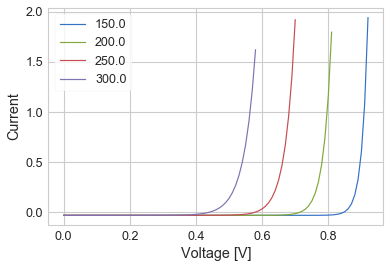

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
leg = []
for i in range(len(T)):
    curve = data[data['T']==T[i]]
    plt.plot(curve['V'],curve['J'])
    leg.append(curve['T'].iloc[0])
#plt.ylim([-0.05,0.1])
plt.legend([str(t) for t in leg])
plt.xlabel('Voltage [V]')
plt.ylabel('Current')
plt.show()

## Attach model
Now we add the function that gives the modeled data - in this case, the `compute_ID` function we just defined above.

In [11]:
m.attach_model(mode='function',func_name=compute_ID)
#m.attach_model(mode='file',fpath='model_data.h5')

That's it! When that function is called, `bayesim` also generates the full table of modeled data at all experimental conditions in the observed data we attached before. Check it out:

In [12]:
m.calc_model_errors()

## Drop that Bayes!
### First Bayes
rewrite explanation here

In [13]:
#m.run(min_num_pts=1,th_pv=.5,th_pm=0.5)
#m.run(th_pv=0.1,th_pm=0.7)
m.run()
#m.run(force_exp_err=True)

Did a total of 32 runs to use a total of 41 observations.

An average of 67 / 100 probability points used model errors (rather than experimental errors) during this run.


We can visualize the distribution and add markers for the real values to compare...

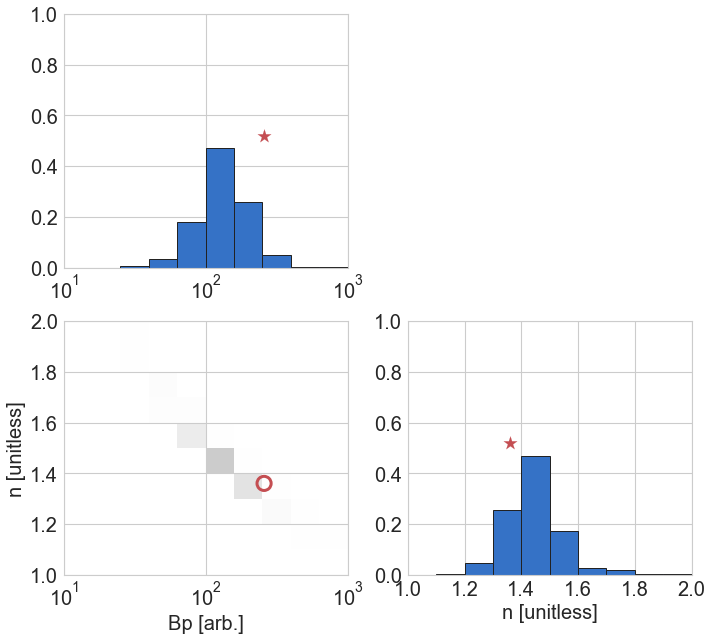

In [14]:
m.visualize_probs(true_vals=params)

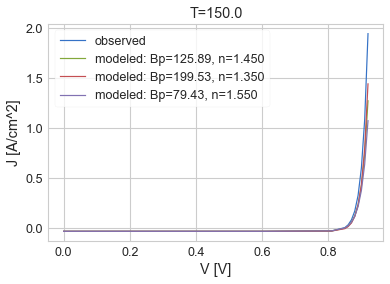

In [15]:
#m.comparison_plot(ecs=[{'T':t} for t in list(set(list(m.ec_pts['T'])))])
m.comparison_plot(num_param_pts=3)

Not too bad. We can also look at the probabilities directly.

In [16]:
m.probs.most_probable(5)

,Bp,Bp_min,Bp_max,n,n_min,n_max,prob,start_ind,end_ind
54,125.89,100.00,158.49,1.45,1.4,1.5,0.465235,3186,3244
63,199.53,158.49,251.20,1.35,1.3,1.4,0.255602,3717,3775
45,79.43,63.10,100.00,1.55,1.5,1.6,0.167433,2655,2713
72,316.20,251.20,398.10,1.25,1.2,1.3,0.046519,4248,4306
37,50.12,39.81,63.10,1.75,1.7,1.8,0.019703,2183,2241


### Let's subdivide!
Again we'll use the default options, which will subdivide all grid boxes with probability > 0.001 as well as any immediately adjacent boxes.

In [17]:
m.subdivide()

15 box(es) with probability > 0.001 and 19 neighboring boxes subdivided!
Overwriting metadata for fitting parameter Bp with new info.
Overwriting metadata for fitting parameter n with new info.
New model points to simulate are saved in the file new_sim_points_1.h5.


Let's take a look at the grid.

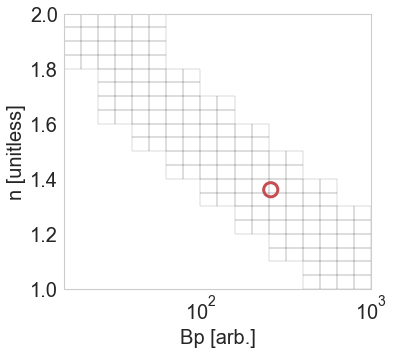

In [18]:
m.visualize_grid(true_vals=params)

### Compute and attach new model data
We've added new model points to the grid so we have to compute the modeled values and attach that data.

In [19]:
new_sims = dd.io.load('new_sim_points_1.h5')

In [20]:
data = []
for sim in new_sims.iterrows():
    v = sim[1]['V']
    t = sim[1]['T']
    this_pt = [v,t,compute_ID({'V':v,'T':t},sim[1])]
    this_pt.extend([sim[1][n] for n in m.fit_param_names()])
    data.append(this_pt)
columns = ['V','T','J']
columns.extend(m.fit_param_names())
new_sim_data = pd.DataFrame.from_records(data=data,columns=columns)
dd.io.save('new_sim_data_1.h5',new_sim_data)

In [21]:
m.attach_model(mode='file',fpath='new_sim_data_1.h5')

In [23]:
m.calc_model_errors()

### Second Bayes!
Let's do it again!

In [24]:
m.run()
#m.run(force_exp_err=True,min_num_pts=1)

Did a total of 38 runs to use a total of 41 observations.

An average of 108 / 136 probability points used model errors (rather than experimental errors) during this run.


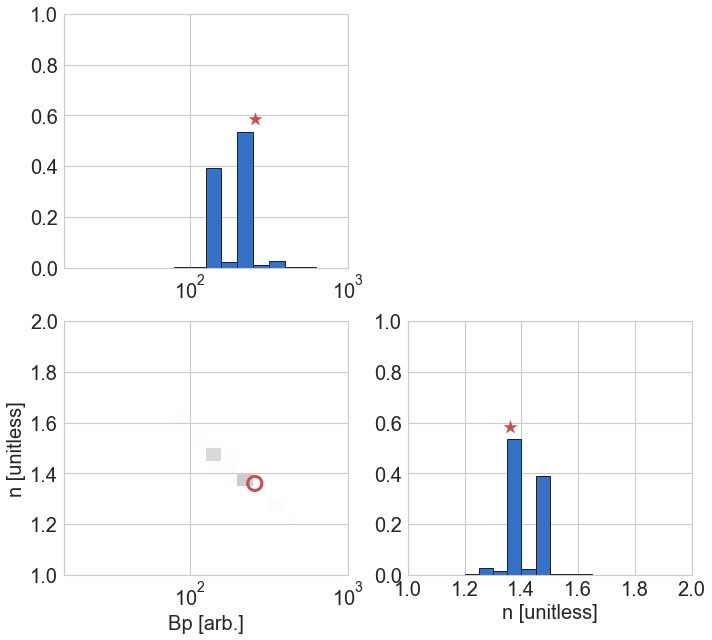

In [25]:
m.visualize_probs(true_vals=params)

In [26]:
m.probs.most_probable(10)

,Bp,Bp_min,Bp_max,n,n_min,n_max,prob,start_ind,end_ind
87,223.90,199.53,251.20,1.375,1.35,1.40,0.529243,5133,5191
71,141.25,125.89,158.49,1.475,1.45,1.50,0.389187,4189,4247
103,354.80,316.20,398.10,1.275,1.25,1.30,0.023317,6077,6135
80,177.83,158.49,199.53,1.425,1.40,1.45,0.018474,4720,4778
96,281.80,251.20,316.20,1.325,1.30,1.35,0.009573,5664,5722
86,223.90,199.53,251.20,1.325,1.30,1.35,0.005533,5074,5132
79,177.83,158.49,199.53,1.375,1.35,1.40,0.003844,4661,4719
70,141.25,125.89,158.49,1.425,1.40,1.45,0.002683,4130,4188
55,89.13,79.44,100.00,1.575,1.55,1.60,0.002163,3245,3303
64,112.20,100.00,125.89,1.525,1.50,1.55,0.001801,3776,3834


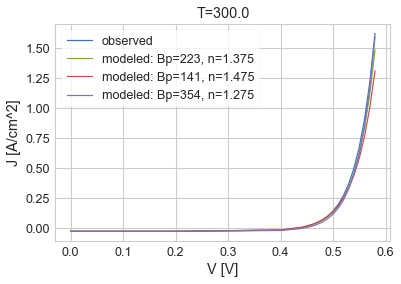

In [27]:
m.comparison_plot(num_param_pts=3)

In [28]:
m.subdivide()

Minimum width/factor of 0.06 already satisfied for n at point: 
Bp             89.130000
Bp_min         79.440000
Bp_max        100.000000
n               1.575000
n_min           1.550000
n_max           1.600000
prob            0.002163
start_ind    3245.000000
end_ind      3303.000000
Name: 55, dtype: float64
Minimum width/factor of 0.06 already satisfied for n at point: 
Bp             89.130000
Bp_min         79.440000
Bp_max        100.000000
n               1.625000
n_min           1.600000
n_max           1.650000
prob            0.001212
start_ind    3304.000000
end_ind      3362.000000
Name: 56, dtype: float64
Minimum width/factor of 0.06 already satisfied for n at point: 
Bp            112.200000
Bp_min        100.000000
Bp_max        125.890000
n               1.525000
n_min           1.500000
n_max           1.550000
prob            0.001801
start_ind    3776.000000
end_ind      3834.000000
Name: 64, dtype: float64
Minimum width/factor of 0.06 already satisfied for n at po

Minimum width/factor of 0.06 already satisfied for n at point: 
Bp            281.800000
Bp_min        251.200000
Bp_max        316.200000
n               1.275000
n_min           1.250000
n_max           1.300000
prob            0.000973
start_ind    5605.000000
end_ind      5663.000000
Name: 95, dtype: float64
Minimum width/factor of 0.06 already satisfied for n at point: 
Bp            354.800000
Bp_min        316.200000
Bp_max        398.100000
n               1.325000
n_min           1.300000
n_max           1.350000
prob            0.000447
start_ind    6136.000000
end_ind      6194.000000
Name: 104, dtype: float64
Minimum width/factor of 0.06 already satisfied for n at point: 
Bp            354.800000
Bp_min        316.200000
Bp_max        398.100000
n               1.225000
n_min           1.200000
n_max           1.250000
prob            0.000515
start_ind    6018.000000
end_ind      6076.000000
Name: 102, dtype: float64
Minimum width/factor of 0.06 already satisfied for n at 

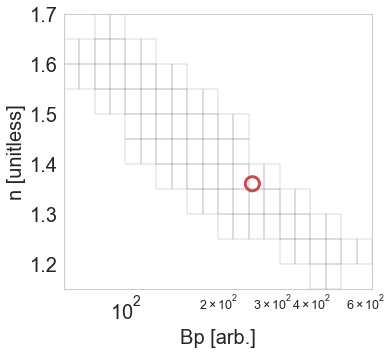

In [29]:
m.visualize_grid(true_vals=params)

In [34]:
m.probs.points.sample(10)

,Bp,Bp_min,Bp_max,n,n_min,n_max,prob,start_ind,end_ind
59,334.90,316.20,354.80,1.275,1.25,1.30,0.009853,3481,3539
30,149.62,141.25,158.49,1.525,1.50,1.55,0.001708,1770,1828
44,211.35,199.53,223.90,1.375,1.35,1.40,0.234750,2596,2654
21,118.85,112.20,125.89,1.625,1.60,1.65,0.000239,1239,1297
17,118.85,112.20,125.89,1.425,1.40,1.45,0.001326,1003,1061
63,375.80,354.80,398.10,1.325,1.30,1.35,0.002707,3717,3775
69,473.20,446.70,501.20,1.275,1.25,1.30,0.003128,4071,4129
53,266.10,251.20,281.80,1.325,1.30,1.35,0.006486,3127,3185
45,211.35,199.53,223.90,1.425,1.40,1.45,0.002546,2655,2713
49,237.10,223.90,251.20,1.375,1.35,1.40,0.222102,2891,2949


In [30]:
new_sims = dd.io.load('new_sim_points_2.h5')
data = []
for sim in new_sims.iterrows():
    v = sim[1]['V']
    t = sim[1]['T']
    this_pt = [v,t,compute_ID({'V':v,'T':t},sim[1])]
    this_pt.extend([sim[1][n] for n in m.fit_param_names()])
    data.append(this_pt)
columns = ['V','T','J']
columns.extend(m.fit_param_names())
new_sim_data = pd.DataFrame.from_records(data=data,columns=columns)
dd.io.save('new_sim_data_2.h5',new_sim_data)
m.attach_model(mode='file',fpath='new_sim_data_2.h5')
m.calc_model_errors()

../../bayesim/model.py:770: RuntimeWarning: invalid value encountered in absolute
  deltas_here = np.absolute(np.diff(mat,axis=i))


In [31]:
m.run()
#m.run(force_exp_err=True)

ValueError: Uh-oh, some probability is NaN!

In [ ]:
m.visualize_probs(true_vals=params)

In [ ]:
m.probs.most_probable(5)

In [ ]:
m.model_data.sample(10)

In [ ]:
m.comparison_plot(num_param_pts=3, num_ecs=3)